In [1]:
import numpy as np
from numpy import array, kron
import qutip
from qutip import Qobj, mesolve, lindblad_dissipator, tensor, basis
import numpy.fft as fft
import matplotlib.pyplot as plt

from scipy import interpolate
from scipy.linalg import expm
import random
# print(qutip.__version__)

import h5py

# Density matrix formalism

In the state vector formalism, we represent the quantum state of a system as a vector $|\psi\rangle$ whose time evolution is governed by the Schrodinger equation $$i\hbar\frac{d|\psi\rangle}{dt} = H|\psi\rangle,$$ where $H$ is the Hamiltonian of our system. The solution to the Schrodinger equation is given formally by $$|\psi(t)\rangle = U|\psi(0)\rangle$$ where $ U = e^{-itH/\hbar}$.  

In the density matrix formalism, we instead describe the state of the system by a density matrix $\rho$. If our system is in a state $|\psi\rangle$ then the density matrix describing our system is given by $\rho = |\psi\rangle\langle\psi|$. In general the density matrix is given by $$\rho = \sum_i p_i |\psi_i\rangle\langle\psi_i|$$ where $\sum_i p_i = 1$ and each $p_i$ represents the probability that our system is in the state $|\psi_i\rangle$. When all the $p_i$ are zero except for one, the state is called a pure state. Otherwise, it is called a mixed state. The time evolution is governed by the von Neumann equation
$$i\hbar \frac{d\rho}{dt} = [H, \rho]$$ 
where the commutator $[A,B] = AB - BA$ for matrices $A$ and $B$. It has the formal solution 
$\rho(t) = U \rho(0) U^\dagger$ where again $U = e^{-itH/\hbar}$. 


# General Notes

To represent a physical state, the density matrix $\rho$ must have trace 1 and be positive semidefinite (all its eigenvalues are nonnegative).

The coherent Hamiltonian $H$ should be Hermitian, so that it is equal to its conjugate transpose.

For most of our applications, the starting state of interest is the vacuum state (qubit in the ground state, and cavity modes with 0 photon population), this is typically represented as the matrix with 1 in the top left entry and 0's everywhere else.

# Wigner tomography class for simulating measurement

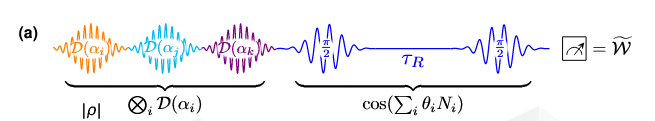
This is the what the actual measurement looks like in experiment. It consists of applying certain pulses to our qubit and cavity modes and at the end measuring the state of the qubit. The operators under the curly braces represent what these operations are in our experiment. The displacement operators $\otimes_i D(\alpha_i)$ represent displacement of each of the cavity modes that happen when we drive the cavity and the phase operator $\cos(\sum_i \theta_i N_i)$ represents the subsequent pulses on the qubit. 

When working in the density matrix formalism, we define the Wigner operator for a single mode as $W = D(\alpha_i)\cos(\theta_i N_i)D(-\alpha_i)$ where $N$ is the number operator that tells us how many photons are in the mode. If we have multiple modes then the total Wigner operator is the tensor product of the Wigner operator for each mode $W_{tot} = \otimes_i W_i.$ Then the result of the measurement is given by the expected value which is given by $Tr(W_{tot}\rho)$ where $\rho$ is the density matrix representing the state of all the cavity modes in the system.

In [2]:
#the maximum number of levels we can simulate in each mode
MAX = 40

class generalized_wigner_tomography_nmodes:
    """
    A Wigner tomography class for simulating measurement. The main purpose of this class
    is to construct the Wigner operator for a multimode system and find its expected value
    for a given state and displacement (point in phase space). This effectively simulates 
    measurement of the system when the system is in some given state.
    
    Attributes
    ----------
    number_of_modes: int
        the number of cavity modes in the system
        
    mode_state_num: int
        the number of levels in each mode to be simulated, i.e. maximum truncated photon number
        
    Methods
    -------
    D(alpha):
        Returns the operator for a displacement to a point in phase space, alpha, for a single mode
    
    Dn(alphas): 
        Returns the displacement operator for an n-mode system.
    
    Phase_op(theta, phi): 
        Returns the phase operator for a single mode with rotation angle-per-photon theta and constant
        phase shift phi
    
    Phase_op_noisy(theta, phi, error):
        Returns the phase operator for a single mode, accounting for imperfections in the pi/2 pulses when 
        performing the measurement in experiment
    
    W_op(alpha):
        Returns the analytic Wigner operator for a single mode in terms of Laguerre polynomials
        
    gen_W_op(theta, alpha, phi=0):
        Returns the generalized Wigner operator for a single mode; generalized in the sense that the
        parity measurement is allowed to be imperfect
        
    gen_W_op_noisy(self, theta, alpha, phi=0, error=0): 
        Returns the generalized Wigner operator for single mode, using Phase_op_noisy() instead of Phase_op()
    
    W_op_nmodes(self, alphas): 
        Returns the analytic Wigner operator for n modes
        
    gen_W_op_nmodes(self, thetas, alphas, phis = None):
        Returns the generalized Wigner operator for n modes
    
    gen_W_op_nmodes_noisy(self, thetas, alphas, phis = None, error=0):
        Returns the generalized noisy Wigner operator for n modes.
    
    W_nmode_expect(self, alphas, rho):
        Returns the expectation value of an n-mode analytic Wigner operator when the system 
        is in state (density matrix) rho
        
    gen_W_nmode_expect(self, thetas, alphas, rho, phis=None):
        Returns the expectation value of an n-mode generalized Wigner operator when the system 
        is in state (density matrix) rho
        
    gen_W_nmode_expect_noisy(self, thetas, alphas, rho, phis=None, error=0):
        Returns the expectation value of am n-mode generalized noisy Wigner operator when the system 
        is in state (density matrix) rho
        
    Note: The analytic Wigner operator methods are only there for completeness; we do not currently use them.
    """
    def __init__(self, number_of_modes=2, mode_state_num=5):
        #mode_state_num should always be <= MAX
        self.m = mode_state_num
        self.num_modes = number_of_modes
        self.I = (np.diag((1+0j) * np.ones(self.m**self.num_modes), 0))
        self.Par = (np.diag(np.exp(1j*np.pi*(np.arange(0, self.m))), 0))

    def D(self, alpha):
        """
        Calculates and returns the displacement operator for a single mode 
        with displacement beta.
        
        Parameters
        ----------
        alpha: complex or float
            the amount to displace by; coordinates of the point in phase space
        
        Returns
        -------
        The displacement operator for a single mode with displacement beta.
        """
        # M_m = a, M_p = a^dag
        M_m = np.diag(np.sqrt(np.arange(1, MAX)), 1)
        M_p = np.diag(np.sqrt(np.arange(1, MAX)), -1)
        return (expm(alpha*M_p - np.conj(alpha)*M_m))[:self.m,:self.m] # restricting to m photons/levels

    def Dn(self,alphas):
        """
        Calculates and returns the displacement operator for an n-mode system.
        
        Parameters
        ----------
        alphas: List
            a list containing the displacement value alpha for each mode,
            should have length number_of_modes, each entry is complex or float
        Returns
        -------
        Multimode displacement operator
        """
        # Displacement operator for the multimode case is a tensor product for each cavity mode
        d = self.D(alphas[0])
        for ii in range(1,self.num_modes): d = kron(d,self.D(alphas[ii]))
        return d
    
    def Phase_op(self,theta, phi=0):
        """
        Returns the phase operator for a single mode with rotation angle theta and phase shift phi.
        In the measurement, the theta corresponds to the rotation angle achieved for a single photon
        when waiting in between the two pi/2 pulses.
        
        Parameters
        ----------
        theta: float
            the rotation angle, should be close to pi
            
        phi: float
            constant additional phase shift
        
        Returns
        -------
        The phase operator for a single mode.
        """
        return ((np.diag(np.cos(phi + theta*(np.arange(0, self.m))), 0)))
    
    def Phase_op_noisy(self, theta, phi=0, error=0):
        """
        Returns the noisy phase operator for a single mode. In the measurement, the 
        theta corresponds to the rotation angle achieved for a single photon
        when waiting in between the two pi/2 pulses.
        
        Parameters
        ----------
        theta: float
            the rotation angle, should be close to pi
            
        phi: float
            constant additional phase shift
        
        error: float
            A percentage error corresponding to how much the 
            pi/2 pulse over/undershoots due to frequency shifts
        
        Returns
        -------
        The noisy phase operator for a single mode.
        """
        # From previous robustness experiments we have seen that the errors scale 
        # quadratically when our pulse over/undershoots. 
        return ((np.diag(np.cos(phi + theta*(np.arange(0, self.m)) + \
                                np.arange(self.m)**2 * theta * error), 0)))
    
    def W_op(self,alpha):
        # Analytic Wigner operator
        N = self.m
        w = np.zeros((N,N),dtype=np.complex)
        B = 4*abs(alpha)**2
        pf = (2/np.pi)*np.exp(-B/2.0)
        for m in range(N):
            x = pf*real((-1)**m*genlaguerre(m, 0)(B))
            w[m, m] = x
            for n in range(m+1, N):
                pf_nm = sqrt(factorial(m)/float(factorial(n)))
                if isinstance(alpha, int):
                    x = pf * pf_nm * (-1)**m * 2 * (2*alpha)**(n-m-1)*genlaguerre(m, n-m)(B)
                else:
                    x = pf * pf_nm * (-1)**m * 2 * (2*alpha.np.conj())**(n-m-1)*genlaguerre(m, n-m)(B)
                if m > 0:
                    y = 8 * pf * pf_nm * (-1)**(m-1)*(2*alpha)**(n-m) *genlaguerre (m-1,n-m+1)(B)
                w[m, n] = alpha * x
                w[n, m] = (alpha * x). conj ()          
        return w
            
    def gen_W_op(self, theta, alpha, phi=0):
        """
        Returns the generalized Wigner operator for a single mode
        
        Parameters 
        ----------
        theta: float
            the rotation angle, should be close to pi
        
        alpha: complex or float
             the displacement, corresponding to a point in phase space
            
        phi: float
            additional constant phase shift
            
        Returns
        -------
        Generalized Wigner operator for a single mode: 2/pi * D(alpha)*Phase_op*D(-alpha)
        
        """
        w = 2 / np.pi * np.dot(self.D(alpha), np.dot(self.Phase_op(theta, phi=phi), self.D(-alpha)))
        return w
    
    def gen_W_op_noisy(self, theta, alpha, phi=0, error=0):
        """
        Returns the generalized noisy Wigner operator for single mode
        
        Parameters 
        ----------
        theta: float
            the rotation angle, should be close to pi
            
        alpha: complex or float
             the displacement, corresponding to a point in phase space
            
        phi: float
            additional constant phase shift
        
        error: float
            A percentage error corresponding to how much the 
            pi/2 pulse over/undershoots due to frequency shifts
            
        Returns
        -------
        Generalized noisy Wigner operator for a single mode: 2/pi * D(alpha)*Phase_op_noisy*D(-alpha)
        
        """
        w = 2 / np.pi * np.dot(self.D(alpha), np.dot(self.Phase_op_noisy(theta, phi=phi, error=error), self.D(-alpha)))
        return w
   
    # analytic Wigner operator for N modes
    def W_op_nmodes(self,alphas):
        w = self.W_op(alphas[0])
        for ii in range(1,len(alphas)):
            w = kron(w,self.W_op(alphas[ii]))
        return w
    
    def gen_W_op_nmodes(self, thetas, alphas, phis=None):
        """
        Returns the generalized Wigner operator for n modes
        
        Parameters
        ----------
        thetas: List
            list containing rotation angle theta for each mode
        
        alphas: List
            list containing the complex displacement for each mode
        
        phis: List
            phase shift for each mode
        
        Returns
        -------
        Generalized Wigner operator for n modes
        
        """
        if phis is None:
            phis = [0] * self.m
        # Wigner operator for the whole system is the tensor product of Wigner operator for each cavity mode
        w = self.gen_W_op(thetas[0],alphas[0], phi=phis[0])
        for ii in range(1,len(alphas)):
            w = kron(w,self.gen_W_op(thetas[ii], alphas[ii], phi=phis[ii]))
        return w

    def gen_W_op_nmodes_noisy(self, thetas, alphas, phis=None, error=0):
        """
        Returns generalized noisy Wigner operator for n-modes
        
        Parameters
        ----------
        thetas: List
            list containing rotation angle theta for each mode
        
        alphas: List
            list containing the complex displacement for each mode
        
        phis: List
            phase shift for each mode
            
        error: float
            A percentage error corresponding to how much the 
            pi/2 pulse over/undershoots due to frequency shifts
        
        Returns
        -------
        Generalized noisy Wigner operator for n modes
        
        """
        if phis is None:
            phis = [0] * self.m
        w = self.gen_W_op_noisy(thetas[0], alphas[0], phi=phis[0], error=error)
        for ii in range(1,len(alphas)):
            w = kron(w,self.gen_W_op_noisy(thetas[ii], alphas[ii], phi=phis[ii], error=error))
        return w


    def W_nmode_2dslice(self, rho, xs, ys, vecs=[[1,0], [1j,0]]):
        vecs = array(vecs)
        return array([[real(np.trace(np.dot(self.W_op_nmodes(x*vecs[0] + y*vecs[1]),rho))) for x in xs] for y in ys])
    
    def gen_W_nmode_2dslice(self, thetas, rho, xs, ys, vecs=[[1,0,0], [1j,0,0]], N=10):
        vecs = array(vecs)
        return array([[real(np.trace(np.dot(self.gen_W_op_nmodes(thetas,x*vecs[0] + y*vecs[1]),rho))) 
                       for x in xs] for y in ys])
    
    # expectation value for analytic Wigner operator
    def W_nmode_expect(self,alphas,rho):
        return np.trace(np.dot(self.W_op_nmodes(alphas),rho))
    
    def gen_W_nmode_expect(self, thetas, alphas, rho, phis=None):
        """
        Calculates and returns the expectation value of n-mode generalized Wigner operator 
        when the system is in state (density matrix) rho. In the density matrix formalism
        the expectation value of an observable M is given by trace(M*rho).
        This corresponds to the ideal result obtained from measuring the observable M
        when the system is in state rho.
        
        Parameters
        ----------
        thetas: List
            list containing rotation angle theta for each mode
        
        alphas: List
            list containing the complex displacement for each mode
            
        rho: matrix
            The density matrix representing the state of the system.
            This should be the density matrix of just the cavity mode
            states. If we have a density matrix of the whole qubit + modes
            system then we need to trace out the qubit before passing 
            the density matrix to this method.

        phis: List
            phase shift for each mode
            
        Returns
        -------
        A float between -(2/pi)^(number_of_modes) and (2/pi)^(number_of_modes) that is the expectation value of 
        the n-mode generalized Wigner operator when the cavity modes are in a state specified by
        the density matrix rho.
        """
        return np.trace(np.dot(self.gen_W_op_nmodes(thetas, alphas, phis=phis), rho))
    
    def gen_W_nmode_expect_noisy(self, thetas, alphas, rho, phis=None, error=0):
        """
        Calculates and returns the expectation value of an n-mode generalized noisy Wigner operator 
        when system is in state (density matrix) rho. In the density matrix formalism
        the expectation value of an observable M is given by trace(M*rho).
        
        Parameters
        ----------
        thetas: List
            list containing rotation angle theta for each mode
        
        alphas: List
            list containing the complex displacement for each mode
            
        rho: matrix
            The density matrix representing the state of the system.
            This should be the density matrix of just the cavity mode
            states. If we have a density matrix of the whole qubit + modes
            system then we need to trace out the qubit before passing 
            the density matrix to this method.

        phis: List
            phase shift for each mode
            
        error: float
            A percentage error corresponding to how much the 
            pi/2 pulse over/undershoots due to frequency shifts
            
        Returns
        -------
        A float between -(2/pi)^(number_of_modes) and (2/pi)^(number_of_modes) that is the expectation value 
        of the n-mode generalized noisy Wigner operator when the cavity modes are in a state specified
        by the density matrix rho.
        
        """
        return np.trace(np.dot(self.gen_W_op_nmodes_noisy(thetas, alphas, phis=phis, error=error),rho))


print("done")

done


# Qutip mesolve Time/Pulse evolution class

## Defining the MM Hamiltonian

In the rotating wave approximation (RWA) and strong dispersive regime, the Hamiltonian when the qubit is coupled to only 1 cavity mode is given by

<!-- $$\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}$$ -->

$$\tilde{\hat{H}} = \frac{\kappa}{2}\hat{a}^{\dagger}\hat{a}\left(\hat{a}^{\dagger}\hat{a}-1\right) +  2\ket{e}\bra{e}\chi\hat{a}^{\dagger}\hat{a} +  \left(\epsilon_{c}(t)+ \epsilon_{q}(t)+\mathrm{c.c.}\right)$$

In general the total system consists of a qubit (transmon) coupled to $n$ cavity modes. The system has $n+1$ subsytems. One is the qubit subsytem and the other $n$ are the subsystems corresponding to each cavity mode. Each of the terms in the Hamiltonian above is a matrix.

In [3]:
# The time dependence of the blockade drive is rotated out.
from itertools import product

class multimode_system:
    """
    A class to represent a multimode system consisting of a qubit coupled to n modes.
    
    ...
    
    Attributes 
    ----------
    qubit_state_num: int 
        number of qubit levels, i.e. the dimension of the qubit Hilbert space 
        
    mode_state_num: int
        number of levels to simulate for each mode, i.e. maximum photon number at which to truncate
        
    number_of_modes: int 
        the number of modes to model in the system
        
    hparams: dict 
        of the form {"chis": [chi for each mode], "kappas": [kappa for each mode]}, 
        calibration parameters for the system Hamiltonian
        
    coherence_params: dict
        List of relevant coherence parameters. Can contain any of the following keys:
            T1_q: T1 decay time of the qubit, expected type is a float or int
            T2_q: dephasing time of the qubit, expected type is a float or int
            nth_q: thermal population of the qubit, expected type is a float
            T1_ms: T1 decay times of the cavity modes, expected type is a list of floats or ints
            nth_ms: thermal population of the cavity modes, expected type is a list of floats
            
    ROTATING: bool
        True if working in the rotating frame, False otherwise, mostly deprecated and should always
        be True for the Hamiltonian matrix to be accurate
        
    Methods
    -------
    H_rot():
        calculates and returns the bare Hamiltonian, i.e. the Hamiltonian without the drive terms, 
        in the rotating frame and dispersive regime
        
    controlHs():
        calculates and returns the rotation operators that make up the drive terms of the total Hamiltonian
        
    totalH(controls):
        given a set of controls, forms and returns the total Hamiltonian using H_rot() and controlHs()
        
    qutip_mesolve(rho, controls, tlist):
        from a starting state rho, time evolves the system using the Lindblad master equation under a
        set of controls specified at each time point in tlist
    """
    def __init__(self, qubit_state_num, mode_state_num, number_of_modes, hparams, coherence_params=None,
                 ROTATING=True):
        """
        Constructs all the necessary attributes for the multimode_system object and all the relevant
        operators needed to define the Hamiltonian matrix
        """
        self.qnum = qubit_state_num
        self.mnum = mode_state_num
        self.mmnum = number_of_modes
        self.ROTATING = ROTATING
        self.hparams = hparams
        self.coherence_params = coherence_params
        transmon_levels = qubit_state_num
        mode_levels = self.mnum

        # qubit rotation matrix around the x-axis
        self.Q_x = np.diag(np.sqrt(np.arange(1, transmon_levels)), 1) + \
                   np.diag(np.sqrt(np.arange(1, transmon_levels)), -1)

        # qubit rotation matrix around the y-axis
        self.Q_y = (0+1j) * (np.diag(np.sqrt(np.arange(1, transmon_levels)), 1) - \
                             np.diag(np.sqrt(np.arange(1, transmon_levels)), -1))

        # qubit rotation matrix around the z-axis
        self.Q_z = np.diag(np.arange(0, transmon_levels))

        # qubit identity matrix
        self.I_q = np.identity(transmon_levels)

        # cavity mode rotation matrix around the x-axis
        self.M_x = np.diag(np.sqrt(np.arange(1, mode_levels)), 1) + \
                   np.diag(np.sqrt(np.arange(1, mode_levels)), -1)

        # cavity mode rotation matrix around the y-axis
        self.M_y = (0+1j) * (np.diag(np.sqrt(np.arange(1, mode_levels)), 1) - \
                             np.diag(np.sqrt(np.arange(1, mode_levels)), -1))

        # cavity mode rotation matrix around the z-axis
        self.M_z = np.diag(np.arange(0, mode_levels))

        # cavity mode identity matrix
        self.I_m = np.identity(mode_levels)

        # annihilation/lowering operator for a single cavity mode
        self.am =  np.diag(np.sqrt(np.arange(1, mode_levels)), 1)

        # annihilation/lowering operator for the qubit
        self.aq =  np.diag(np.sqrt(np.arange(1, self.qnum)), 1)
        
        # everything defined above was only for each subsystem, to form the real operators 
        # that act on the whole system we need to take tensor products of one of the 
        # operators for each of the subsystems in the total system
        
        # for example, if we have 3 modes and want M_x for the second cavity mode, then 
        # this is 
        # $I_q \otimes I_1 \otimes M_x \otimes I_3$ 
        
        # arrays of M_z, M_x, M_y, and a for each cavity mode while not acting 
        # (having the identity) on each of the other subsystems

        self.M_zs, self.M_xs, self.M_ys, self.ams  =  [],[],[],[]
        # taking the tensor products for the cavity modes
        for k in np.arange(self.mmnum):
            mmz = self.M_z*(k==0) + self.I_m*(1-(k==0))
            mmx = self.M_x*(k==0) + self.I_m*(1-(k==0))
            mmy = self.M_y*(k==0) + self.I_m*(1-(k==0))
            mma = self.am*(k==0) + self.I_m*(1-(k==0))
            for m in np.arange(1, self.mmnum):
                mmz = np.kron(mmz, self.M_z*(k==m) + self.I_m*(1-(k==m)))
                mmx = np.kron(mmx, self.M_x*(k==m) + self.I_m*(1-(k==m)))
                mmy = np.kron(mmy, self.M_y*(k==m) + self.I_m*(1-(k==m)))
                mma = np.kron(mma, self.am*(k==m) + self.I_m*(1-(k==m)))
            self.M_zs.append(mmz)
            self.M_xs.append(mmx)
            self.M_ys.append(mmy)
            self.ams.append(Qobj(np.kron(self.I_q, mma)))
        self.I_mm = self.I_m
        for m in np.arange(1,self.mmnum): 
            self.I_mm = np.kron(self.I_mm, self.I_m)
        # annihilation operator for the qubit tensored with the identity operator for 
        # all the cavity modes
        self.aqmm = Qobj(np.kron(self.aq, self.I_mm))
    
    def H_rot(self):
        """
        Returns the bare Hamiltonian of the system without any of the drive terms.
        This governs the free evolution of the system in the absence of driving.
        """
        chis, kappas = self.hparams["chis"], self.hparams["kappas"]
        freq_ge, mode_ens = 0, 0  # GHz, in lab frame
        chi_mat = np.zeros(self.qnum)
        chi_2_mat = np.zeros(self.qnum)
        
        for ii,chi in enumerate(chis):
            mode_freq = 0
            chi_mat[1] = chi

            # self-Kerr terms
            mode_ens = np.array([2*np.pi*mm*(mode_freq - 0.5*(mm-1)*kappas[ii]) for mm in np.arange(self.mnum)]) 
            # does not include the cross-Kerr interactions between cavity modes

            H_m = np.diag(mode_ens)
            ret = H_m*(ii==0) + self.I_m*(1-(ii==0))
            for m in np.arange(1,self.mmnum):
                ret = np.kron(ret,H_m*(ii==m) + self.I_m*(1-(ii==m)))
            H0 = np.kron(self.I_q, ret)           
            H0 += 2 * 2* np.pi*(np.kron(np.diag(chi_mat), (self.M_zs[ii])))
        return H0

    
    def controlHs(self):
        """
        Returns the rotation operators that make up the drive terms in our Hamiltonian.
        
        Returns
        -------
        List of rotation operators in the form
        [x qubit rotation, y qubit rotation, mode 1 x rotation, mode 1 y rotation, ..., 
        mode mnum x rotation, mode mnum y rotation]
        
        """
        controlHs = []
        XI = np.kron(self.Q_x, self.I_mm)
        YI = np.kron(self.Q_y, self.I_mm)
        controlHs.append(XI)
        controlHs.append(YI)
        for m in np.arange(self.mmnum):
            IX = np.kron(self.I_q, self.M_xs[m])
            IY = np.kron(self.I_q, self.M_ys[m])
            controlHs.append(IX)
            controlHs.append(IY)
        return controlHs
    

    def total_H(self, controls):
        """
        Returns the total Hamiltonian at each time step in a format that can be fed into qutip.mesolve().
        This defines a time-dependent Hamiltonians in QuTiP using the method in [0].
        
        [0] https://qutip.org/docs/latest/guide/dynamics/dynamics-time.html#:~:text=Array%20Based%3A%20The,the%20given%20times.
        
        Parameters 
        ----------
        controls: List
            a list of the form [[qubit control x], [qctrl y], [mode1cntrlx], [mode1cntrly], ...] where the lists
            are floats that model the values of the controls at each time step
    
        Returns
        -------
        A list of the form 
        [H_bare, [H_drive_qubit_x, [control coefficient for qubit rotation about x at each time step], 
        [H_drive_qubit_y, [control coeffs at each time step]], ...]
        
        """
        if self.ROTATING:
            H = [Qobj(self.H_rot())]
            controlHs = self.controlHs()
            #controls give the coefficient value for each of the controlHs at each time step
            for index in range(len(controls)):
                H.append([Qobj(controlHs[index]), controls[index]]) 
        else: H = 0
        return H
    
    def qutip_mesolve(self, rho, controls, tlist):
        """
        From a starting density matrix rho, time evolves the system using the Lindblad master equation under a
        set of controls specified at each time point in tlist
        
        Parameters
        ----------
        rho: QuTiP Qobj
            input state density matrix
    
        controls: List 
            of the form [[qubit control x], [qctrl y], [mode1cntrlx], [mode1cntrly], ...] where the lists
            are the values of the controls at each time in tlist
            
        tlist: List
            list of times (dtype float) starting from 0.0 to the final time, such as in increments of some
            dt, although this is not strictly required.
        
        Returns
        -------
        A QuTiP Result object from which we can get the density matrix at the final time in tlist.
        
        """
        
        H = self.total_H(controls)
        if self.coherence_params is None:
            c_ops = []
        else:
            gamma = 1/self.coherence_params['T1_q'] * 1e-3
            gamma_phi = 1/self.coherence_params['T2_q'] * 1e-3- 1/2/self.coherence_params['T1_q'] * 1e-3
            n_thq = self.coherence_params['nth_q']
            c_ops = gamma*(1+n_thq)*lindblad_dissipator(self.aqmm) + \
                    gamma * (n_thq) * lindblad_dissipator(self.aqmm.dag())
            c_ops += gamma_phi * lindblad_dissipator(self.aqmm.dag() * self.aqmm) 
            kappa_ms = 1/array(self.coherence_params['T1_ms'])*1e-3
            n_thms =  array(self.coherence_params['nth_ms'])
            for ii,a in enumerate(self.ams):
                c_ops += kappa_ms[ii]*(1 + n_thms[ii]) * lindblad_dissipator(a) + \
                         kappa_ms[ii]*(n_thms[ii]) * lindblad_dissipator(a.dag()) 
        out = mesolve(H, Qobj(rho), tlist, c_ops=c_ops)
        return out   
print('done')

done


# Defining functions F and G

## F (state forward time evolution under given controls)

The Schrodinger equation governs the time evolution of a closed quantum system. Here, however, we want to model decoherence effects that the environment has on our system. Hence, we treat it as an open quantum system.

We time evolve the system using the Lindblad master equation which governs the evolution of an open quantum system under the assumption of Markovian dynamics. An explanation of the Lindblad master equation can be found in the first paragraph of [0].

[0] https://qutip.org/docs/latest/guide/dynamics/dynamics-master.html#the-lindblad-master-equation


In [4]:
# System Parameters
# chis, kappas in GHz
chis = [-0.001086790631783979, -0.0008180478434564318, -0.0006351130686961963, -0.0005466789183518643,
        -0.00045383158058350865, -0.00035975283945200223, -0.00035049899366200476, -0.00030601280625028933, 
        -0.000266282492397205]
kappas = [0.0, 9.02e-6, 5.23e-6, 4.19e-6, 3.24e-6, 1.4e-6, 1.48e-6, 0.72e-6, 0.0]

# T1 times in ns
T1ms = np.array([0.833, 0.895, 1.315, 1.496, 0.776, 1.582, 1.439, 0.886, 1.048]) * 1e3

# the cavity modes that we want to use
modelist = [3]

# number of qubit and cavity levels to include in the model
qubit_levels, mode_levels = 2, 10

chi_list,kappa_list = [], []
for mode in modelist:
    chi_list.append(chis[mode])  # units of GHz
    kappa_list.append(kappas[mode])  # units of GHz

# Lists of the relevant Hamiltonian parameters
# chis: dispersive shift (change in the qubit frequency) for each cavity photon added to the system
# kappas: quadratic (scaling with n^2) shift of the cavity frequency when it contains n photons
hparams = {"chis": chi_list, "kappas": kappa_list}

# List of relevant coherence parameters
# T1_q: T1 decay time of the qubit
# T2_q: dephasing time of the qubit
# nth_q: thermal population of the qubit
# T1_ms: T1 decay times of the cavity modes, expected type is a list
# nth_ms: thermal population of the cavity modes, expected type is a list
coherence_params = {"T1_q": 100e-3, "T2_q": 150e3, "nth_q": 0.015, "T1_ms": T1ms[modelist], "nth_ms": [0.005]}

# If want to model the system without any cost operators, uncomment the following line:
# coherence_params = None

In [5]:
def quantize_controls(controls, resolution=0.116e-3):
    """
    Function that simulates the quantization effects of the control electronics controls
    used in the experiment.
    
    controls: List
        a list of the form [[qubit control x], [qctrl y], [mode1cntrlx], [mode1cntrly], ...] 
        where the lists are the values of the controls at each time step
        
    resolution: float
        The resolution or quantization step size of the control electronics
    
    """
    quantized_controls = []
    for control_array in controls:
        quantized_array = [np.floor(control_point // resolution) * resolution for control_point in control_array]
        quantized_controls.append(quantized_array)
    return np.array(quantized_controls)


def time_evol_f(rho, controls, tlist, qubit_state_num, mode_state_num, 
                number_of_modes, hparams, coherence_params=None):
    """
    Function that, given an input density matrix (state) rho, evolves rho under controls, returning the
    final density matrix at the last time in tlist
    
    rho: input state matrix, as a 2D numpy array
    
    controls: a list of the form [[qubit control x], [qctrl y], [mode1cntrlx], [mode1cntrly], ...] where the lists
    are the values of the controls at each time in tlist
    
    tlist: List
        list of times (dtype float) starting from 0.0 to the final time, such as in increments of some
        dt although this is not strictly required.
        
    qubit_state_num: int 
        number of qubit levels i.e. the dimension of the qubit Hilbert space 
        
    mode_state_num: int
        number of levels to simulate for each mode 
        
    number_of_modes: int 
        the number of modes the qubit is coupled to 
        
    hparams: dict 
        of the form {"chis": [chi for each mode], "kappas": [kappa for each mode]}, 
        calibration parameters for the Hamiltonian
        
    coherence_params: dict
        List of relevant coherence parameters. Can contain any of the following keys:
            T1_q: T1 decay time of the qubit
            T2_q: dephasing time of the qubit
            nth_q: thermal population of the qubit
            T1_ms: T1 decay times of the cavity modes, expected type is a list
            nth_ms: thermal population of the cavity modes, expected type is a list
    """
    if type(rho) == qutip.qobj.Qobj:
        rho = rho.full()  # convert rho to a numpy array if it is specified as a Qobj
    msys = multimode_system(qubit_state_num, mode_state_num, number_of_modes, hparams, 
                            coherence_params=coherence_params)
    out = msys.qutip_mesolve(rho, controls, tlist)
    # return the final state density matrix at the final time in tlist
    return out.states[-1]

In [6]:
# This cell tests the quantize_controls() and time_evol_f() functions
# To simulate the effect from digitization of the controls one should first pass the controls 
# to quantize_controls() and then feed the result into time_evol_f


# initial state
psi = tensor(basis(qubit_levels, 0), basis(mode_levels, 0))
# density matrix corresponding to initial state
rho = psi * psi.dag()
rho = rho.full()
controls = np.ones((4,100)) * 5e-3 * 2 * np.pi
controls = quantize_controls(controls)
# print(controls)
# print(quantize_controls(controls, 0.25e-3))
tlist = np.arange(100) * 100.0

out = time_evol_f(rho, controls, tlist, qubit_levels, mode_levels, len(modelist), 
                  hparams, coherence_params=coherence_params)

## G (simulation of measurement)

Recall that the Wigner operator that corresponds to the measurement we are making in the experiment is given by
$$W_{tot} = \otimes_i W_i$$ 
where here we are summing over all the modes in our system and $$W_i = D(\alpha_i)\cos(\theta_iN_i)D(-\alpha_i).$$ We can simulate a measurement under the effects of experimenatal noise by modeling uncertainty in the $\alpha_i$ and $\theta_i$ of each $W_i$.


In [7]:
def meas_sim_g(rho, alphas, number_of_modes, mode_state_num, readout_fidelity=1, acquisition_num=1000, phase_error=0):
    """
    Given a state rho and a list of displacement alphas corresponding to a measurement point, 
    calculate the expected value of the measurement under the effects of experimental noise.
    
    This method captures three sources of noise:
        1) The readout fidelity, which captures how well we can distinguish the qubit ground and excited states.
        2) Errors in the thetas of the phase operator cos(theta*N)
        3) Errors in the alphas of the displacement operator D(\alpha)
    
    To model the errors in the alphas, one should first feed the alphas 
    to the function add_alpha_uncertainty(alphas, noise_percent) before 
    passing them to this function.
    
    Parameters 
    ----------
    rho: matrix
        density matrix representing the state of the system
        
    alphas: List
        a list containing the displacement value alpha for each mode
        should have length number_of_modes
    
    number_of_modes: int
        the number of cavity modes in our system
        
    mode_state_num: int
        the number of levels in each mode that we simulate
    
    readout_fidelity: float
        should be between 0.0 and 1.0 inclusive. 
        readout_fidelity = 1.0 means we can always measure the state perfectly
        readout_fidelity = 0.0 means the measurement is like flipping a coin and has a 
        50/50 chance of being correct (we cannot distinguish between qubit states)
    
    acquisition_num: int
        the number of times that the measurement is repeated, typically 100-1000 in the experiment 
        
    phase_error: float
        the percentage error that simulates inaccuracy in the pi/2 pulses
    
    Returns
    -------
    The result of a parity measurement at the point specified by the alphas.
    Returns a float between 0 and 1.
    For a single run of the experiment in the lab, a value of 0 means there 
    are a total even number of photons in the modes and a value of 1 means there
    are a total odd number; each experiment will either give 0 or 1.
    Hence, the expected value will be between 0 and 1.
    
    Note
    ----
    The default values of readout_fidelity, acquistion_num, and phase_error 
    are set to model a perfect, noise-free measurement. If you want just the 
    raw no-noise parity measurement then set acquistion_num=1.
    
    """
    w = generalized_wigner_tomography_nmodes(number_of_modes=number_of_modes, mode_state_num=mode_state_num)
    meas_W = w.gen_W_nmode_expect_noisy(theta_set, alphas, rho, error=phase_error)
    meas_W_noisy = meas_W
    running_sum = 0
    # simulate measuring the same point many times
    if acquisition_num == 1 and phase_error == 0 and readout_fidelity == 1:
        print("Returning ideal value")
        return np.real((w.gen_W_nmode_expect(theta_set, alphas, rho) * (-np.pi/2)**number_of_modes + 1)/2)
    for j in range(acquisition_num):
        single_meas = np.sign(2 * random.random() - 1 + (np.pi / 2)**len(alphas) * \
                              (1-2*(1-readout_fidelity)) * meas_W_noisy)  # gives either -1 or 1
        single_meas = 1/2 * -single_meas + 1/2  # rescale to either 0 or 1
        running_sum += single_meas
    # meas_P = (meas_W_noisy * (-pi/2) + 1) / 2    running_sum /= acquisition_num
    return running_sum

def add_alpha_uncertainty(alphas, noise_percent):
    """
    Models noise in the displacement operator gate when it is performed in the experiment. 
    We assume Gaussian noise.
    
    Parameters
    ----------
    alphas: List
        a list containing complex numbers that are the displacement value alpha for each mode,
        should have length number_of_modes
    
    noise_percent: float
        percent that sets the noise in the displacement
    """
    noisy_alphas_real = np.random.normal(
        np.real(alphas), 
        noise_percent * np.abs(np.array(alphas))
    )

    noisy_alphas_imag = np.random.normal(
        np.imag(alphas), 
        noise_percent * np.abs(np.array(alphas))
    )

    return noisy_alphas_real + 1j * noisy_alphas_imag

In [8]:
# This cell shows an example of how to use the meas_sim_g() method.

# Measurement simulation parameters
readout_fidelity = 0.95  # percentage of ability to distinguish the qubit ground and excited states, maximum value 1.0
acquisition_num = 1000  # number of averages (repetitions) of each measurement
theta_set = [np.pi]
# theta_set = [3.2, 2.95]  # thetas for multiple modes will be different for each mode
number_of_modes = 1
qubit_levels = 2
mode_state_num = 10

# Define the initial state of the system.
psi = tensor(basis(qubit_levels, 0), basis(mode_state_num, 1))
rho = psi * psi.dag()
rho = Qobj(rho)

def trace_out_qubit(rho, number_of_modes):
    """
    Traces out the qubit from the density matrix of the whole qubit + modes system 
    and returns the density matrix of just the modes, using the ptrace() method from qutip
    
    Parameters
    ----------
    rho: QuTiP QObj
        density matrix of the whole qubit + modes system
        
    number_of_modes: int
        the number of cavity modes in the system
    
    Returns
    -------
    The density matrix of the subsystem consisting of all the modes as a Qobj.
    """
    trace_list = np.arange(number_of_modes) + 1
    print(trace_list)
    return rho.ptrace(trace_list)


def trace_out_qubit_v2(rho, number_of_modes, qubit_levels, mode_levels):
    """
    Traces out the qubit from the density matrix of the whole qubit + modes system 
    and returns the density matrix of just the modes, assuming the qubit is the first subspace
    and the modes are the following ones
    
    Parameters
    ----------
    rho: 2D numpy array
        density matrix of the whole qubit + modes system
        
    number_of_modes: int
        the number of cavity modes in the system
        
    qubit_levels: int
        the number of qubit energy levels to model in the system
        
    mode_levels: int
        the number of cavity energy levels to model in the system
    
    Returns
    -------
    The density matrix of the subsystem consisting of all the modes as a 2D numpy array.
    """
    if type(rho) == qutip.qobj.Qobj:
        rho = rho.full()
    if len(rho) != qubit_levels * mode_levels ** number_of_modes:
        print("Incompatible density matrix shape!")
        return
    return np.trace(rho.reshape(qubit_levels, mode_levels**number_of_modes,
                       qubit_levels, mode_levels**number_of_modes), axis1=0, axis2=2)


# Trace out the qubit so that our density matrix is only that of the cavity modes.
cavity_rho = trace_out_qubit_v2(rho, number_of_modes, qubit_levels, mode_state_num)
alpha_displacements = [0.5j]

#ideal no-noise measurement 
print(meas_sim_g(cavity_rho, alpha_displacements, number_of_modes, mode_state_num, 1, 1, 
           phase_error = 0))

# To model the alpha uncertainty we first feed our alphas into add_alpha_uncertainty
alpha_displacements = add_alpha_uncertainty(alpha_displacements, 0.01)
print(alpha_displacements)

# Then we run meas_sim_g after modeling the uncertainties in the alphas
print(meas_sim_g(cavity_rho, alpha_displacements, number_of_modes, mode_state_num, readout_fidelity, acquisition_num, 
           phase_error = -0.015))


Returning ideal value
0.5000000000378645
[-0.01008014+0.49671968j]
(496+0j)


# Example: Preparing Fock State |g1>

This is a demonstration of doing the state transfer problem $|g0\rangle$ to $|g1\rangle$ using controls that we generated using GRAPE. We are starting in the ground state (qubit in the ground state, 0 photons in the cavity) and then putting 1 photon in the cavity.

In [9]:
# initial state |g0>
psi = tensor(basis(qubit_levels, 0), basis(mode_levels, 0))
# density matrix corresponding to initial state
rho = psi * psi.dag()
rho = rho.full()

# final state |g1> 
psif = tensor(basis(qubit_levels, 0), (basis(mode_levels, 1)))
# density matrix corresponding to expected final state
rhof = psif*psif.dag()

#file that contains an optimal control pulse that prepares the Fock state |g1>
filename = "00004_g0_to_g1_SNAP_qamp10.63_camp0.54_mode3.h5"

# read the controls from the file
with h5py.File(filename,'r') as hf:
    last_u0 = np.array(hf['uks'])[-1]
    time = hf['total_time'][()]
    steps = hf["steps"][()]

controls = last_u0
tlist = np.linspace(0.0, time, steps)
controls

array([[ 1.5154928e-05, -1.5269363e-05, -2.7085383e-05, ...,
        -1.4262837e-04, -6.8650275e-05, -1.4742674e-05],
       [-1.7753096e-05, -9.4489797e-06, -1.7699436e-05, ...,
         5.1731993e-05,  2.1142690e-05,  4.9059217e-06],
       [-9.1817498e-07,  1.6814089e-05,  3.4945442e-05, ...,
        -3.4643970e-05, -1.7160710e-05, -3.1033875e-07],
       [ 6.5852367e-07, -1.8381084e-05, -3.5333604e-05, ...,
        -1.7929526e-05, -9.5220039e-06,  1.9294168e-06]], dtype=float32)

In [10]:
def plot_controls(tlist, controls):
    fig, ax = plt.subplots(figsize=(10,7))
    controls = controls.transpose()
    ax.plot(
        tlist, 
        controls, 
        label=[r'$a_{q,x}$', r'$a_{q,y}$', r'$a_{c,x}$', r'$a_{c,y}$']
    )
    ax.legend()
    plt.show()

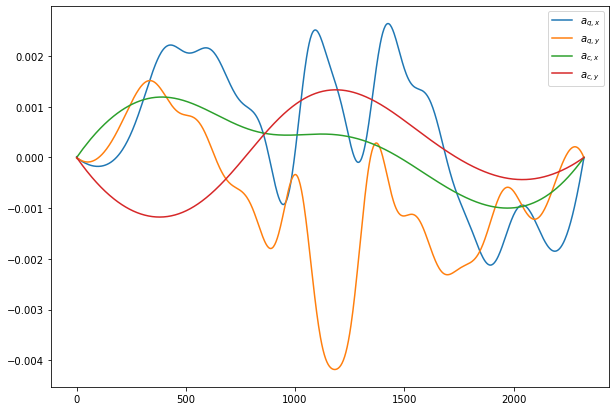

In [11]:
plot_controls(tlist, controls)

In [12]:
msys = multimode_system(
    qubit_levels, 
    mode_levels, 
    len(modelist), 
    hparams, 
    coherence_params=coherence_params
)


with h5py.File('g0_to_g1_multimode_system_data.h5', 'w') as hf:
    hf.create_dataset('H_drift', data=msys.H_rot())
    hf.create_dataset('H_drives', data=np.stack(msys.controlHs()))
    hf.create_dataset('psi1', data=psi.data.toarray())
    hf.create_dataset('psif', data=psif.data.toarray())
    hf.create_dataset('tlist', data=tlist)
    hf.create_dataset('controls', data=controls)



ValueError: x and y must have same first dimension, but have shapes (800,) and (600, 4)

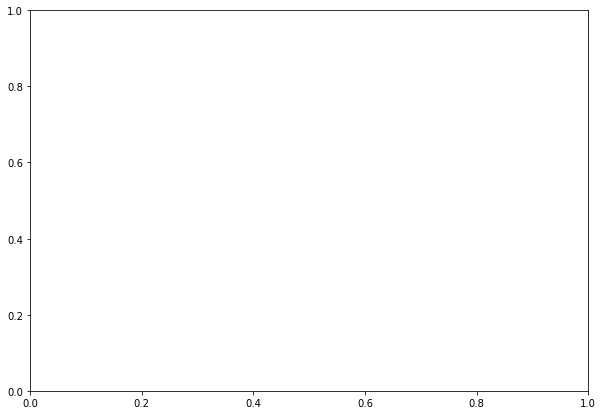

In [13]:
with h5py.File('controls_data.h5', 'r') as hdf:
    pico_controls = np.array(hdf['controls'])

plot_controls(tlist, pico_controls.transpose())

In [ ]:
H0 = np.array([[1, 2], [3,4]])
His = [np.array([[1,2], [3,4]]), np.array([[5,6], [7,8]]), np.array([[9,10], [11,12]])]

with h5py.File('matrix_transpose_test.h5', 'w') as f:
    f.create_dataset('H0', data=H0)
    f.create_dataset('His', data=His)

In [ ]:
# time evolve the intial state under the controls 
out = time_evol_f(rho, controls, tlist, qubit_levels, mode_levels, len(modelist), hparams)

# check that final state after evolution under the controls is close to |g1> i.e fidelity ~1
print(qutip.fidelity(Qobj(rhof.full()), Qobj(out)))


0.6877410939250835


In [ ]:
cavity_rho_out = trace_out_qubit_v2(out, number_of_modes, qubit_levels, mode_state_num)
alpha_displacements = [0]

#no-noise measurement with no displacement
meas_sim_g(cavity_rho_out, alpha_displacements, number_of_modes, mode_state_num, readout_fidelity = 1, 
           acquisition_num = 1, phase_error = 0)
#the result is effectively 1, which tells us that there are an odd number of photons in the
#cavity mode which makes sense since the state is |g1>

Returning ideal value


0.9918171927380912

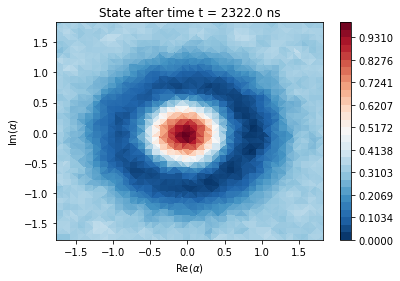

In [ ]:
# Now by measuring the state with meas_sim_g() at a variety of alphas (points in the phase space) 
# we can effectively visualize/reconstruct the density matrix.

# measure at a bunch of alphas (points in phase space)
alphas2 = np.arange(-np.sqrt(7) / np.sqrt(2) + 0.1, np.sqrt(7) / np.sqrt(2), 0.1)

# real part of alphas
alpha_rs = []
# imaginary part of alphas
alpha_is = []
meas_results = []

# measure at each of the alphas
for alpha_r in alphas2: 
    for alpha_i in alphas2: 
        alpha_rs.append(alpha_r)
        alpha_is.append(alpha_i)
        meas_results.append(np.real(meas_sim_g(cavity_rho_out, [alpha_r + alpha_i*1j], number_of_modes, mode_state_num, readout_fidelity, acquisition_num, 
                   phase_error = -0.015)))
        
def plot_meas(alpha_rs, alpha_is, meas_results, step, tlist):
    """
    Plots the result of meas_sim_g for various displacements alpha.
    This is effectively a plot of the density matrix.

    Parameters
    ----------
    alpha_rs: List
        a list (dtype float) of the real parts of the displacments alpha
    
    alpha_is: List
        a list (dtype float) of the imaginary parts of the displacements alpha.
    
    meas_results: List
        a list (dtype float) of the measurement results
        
    alpha_rs, alpha_is, and meas_results should all have the same length
    
    each value meas_result[index] in meas_result should be the result 
    of measuring at the corresponding alpha given by 
    alpha_rs[index] + 1j*alpha_is[index]
    
    Returns
    -------
    Plot of the measurement of a state as given by meas_results.
    
    """
    cmap = 'RdBu_r'
    fig, ax = plt.subplots()
    ax.tripcolor(alpha_rs, alpha_is, meas_results, cmap=cmap)
    tcf = ax.tricontourf(alpha_rs,alpha_is,meas_results,np.linspace(0,1,30),cmap=cmap)
    #ax.plot(alpha_rs,alpha_is, 'g. ')
    if step == 0: 
        time = np.floor(tlist[step])
    else: 
        time = np.floor(tlist[step - 1])
    ax.set_title(f"State after time t = {time} ns")
    ax.set_ylabel(r'Im($\alpha$)')
    ax.set_xlabel(r'Re($\alpha$)')
    fig.colorbar(tcf)
    plt.show()
    
# plot of the measurement of the state after the initial state |g0> has been time evolved under the controls
# to |g1>
plot_meas(alpha_rs, alpha_is, meas_results, len(tlist), tlist)

Pulse takes total time 2322.0 ns


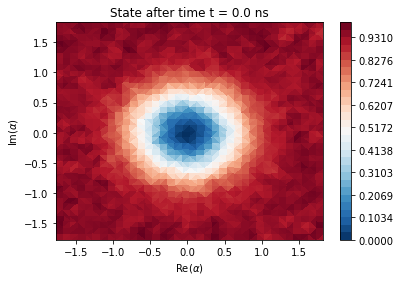

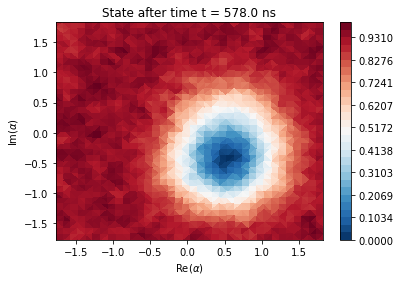

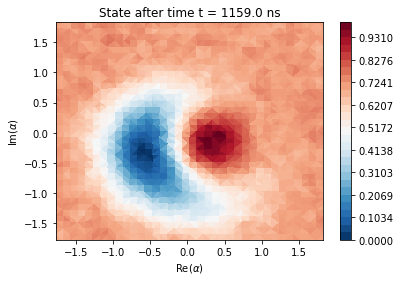

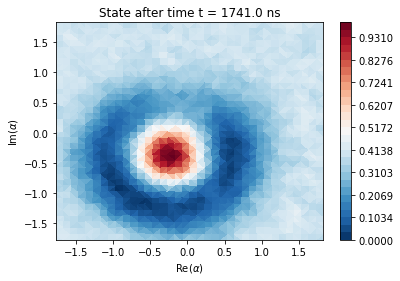

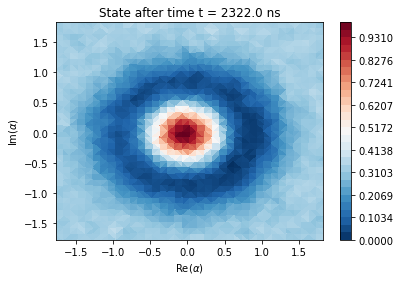

In [ ]:
# This cell shows what happens if we interrupt the trajectory at intermediate points in the middle
# and measure the state.

tf = np.floor(tlist[-1])
print(f"Pulse takes total time {tf} ns")

def plot_traj(rho, controls, tlist, qubit_levels, mode_levels, number_of_modes, readout_fidelity, 
              acquisition_num, phase_error = -0.015):
    """
    Measures the state at intermediate values in the trajectory and plots
    the result. This effectively shows the evolution of the density matrix
    over the trajectory.
    
    Parameters
    ---------
    rho: matrix
        density matrix of the initial state
        
    controls: a list of the form [[qubit control x], [qctrl y], [mode1cntrlx], [mode1cntrly], ...] where the lists
    are the values of the controls at each time in tlist
    
    tlist: List
        list of times (dtype float) starting from 0.0 to the final time, such as in increments of some
        dt although this is not strictly required.
        
    qubit_levels: int 
        number of qubit levels i.e. the dimension of the qubit Hilbert space 
        
    mode_levels: int
        number of levels to simulate for each mode 
        
    number_of_modes: int 
        the number of modes the qubit is coupled to 
        
    readout_fidelity: float
        should be between 0.0 and 1.0 inclusive. 
        readout_fidelity = 1.0 means we can always measure the state perfectly
        readout_fidelity = 0.0 means the measurement is like flipping a coin and has a 
        50/50 chance of being correct (we cannot distinguish between qubit states)
    
    acquisition_num: int
        the number of times that the measurement is repeated, typically 100-1000 in the experiment 
        
    phase_error: float
        the percentage error that simulates inaccuracy in the pi/2 pulses
    
    Returns
    -------
    Plots of measurements of the state at intermediate parts of the trajectory.
    
    """
    # list of intermediate time steps to evaluate the trajectory till
    steps = np.arange(0, len(controls[0]) + 100, 200)
    
    alphas2 = np.arange(-np.sqrt(7)/np.sqrt(2)+0.1,np.sqrt(7)/np.sqrt(2),0.1)
    alpha_rs = []
    alpha_is = []
    for alpha_r in alphas2: 
        for alpha_i in alphas2: 
            alpha_rs.append(alpha_r)
            alpha_is.append(alpha_i)
    
    for step in steps: 
        meas_results = []
        if step == 0:
            rho_i = trace_out_qubit_v2(rho, number_of_modes, qubit_levels, mode_state_num)
            for alpha_r in alphas2: 
                for alpha_i in alphas2: 
                    meas_results.append(np.real(meas_sim_g(rho_i, [alpha_r + alpha_i*1j], number_of_modes, 
                                                           mode_state_num, readout_fidelity, acquisition_num, 
                                                           phase_error = phase_error)))
            plot_meas(alpha_rs, alpha_is, meas_results,step, tlist)
        else:
            trunc_controls = [[], [], [] ,[]]
            for i in range(len(controls)):
                trunc_controls[i] = controls[i][:step]
            out = time_evol_f(rho, trunc_controls, tlist[:step], qubit_levels, mode_levels, len(modelist), hparams)
            cavity_rho_out = trace_out_qubit_v2(out, number_of_modes, qubit_levels, mode_state_num)
            
            meas_results = []
            for alpha_r in alphas2: 
                for alpha_i in alphas2: 
                    meas_results.append(np.real(meas_sim_g(cavity_rho_out, [alpha_r + alpha_i*1j], number_of_modes, 
                                                           mode_state_num, readout_fidelity, acquisition_num, 
                                                           phase_error = -0.015)))
            plot_meas(alpha_rs, alpha_is, meas_results, step, tlist)
            
plot_traj(rho, controls, tlist, qubit_levels, mode_levels, len(modelist), readout_fidelity, acquisition_num)